# Exploración y pre-procesamiento de la data

In [1]:
# Importo las librerías iniciales que voy a usar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Abro los archivos de training y testing que da la competencia
df_test = pd.read_csv('test.csv', index_col=0)
df_train = pd.read_csv('train.csv', index_col=0)

## Procesamiento de merge dataset

In [3]:
# junto los dos datasets para procesarlos
final_df = pd.concat([df_train,df_test],axis=0)

In [4]:
# Exploro el archivo
print(f'Tamaño del df:', final_df.shape)
print(f'Tipos de datos en las columnas:')
print(final_df.dtypes.value_counts())
#df_train.describe()

Tamaño del df: (2919, 80)
Tipos de datos en las columnas:
object     43
int64      25
float64    12
dtype: int64


Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SalePrice'],
      dtype='object')

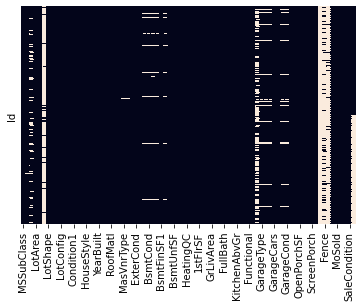

In [5]:
# Chequeo en que columnas hay valores nan
sns.heatmap(final_df.isnull(), yticklabels = False, cbar = False)
final_df.columns[final_df.isna().any()]

In [6]:
# Me fijo el porcentaje de valores nan que hay en cada una de esas columnas
columns_with_nan = final_df.isna().sum()/2919*100
columns_with_nan.sort_values(ascending=False).head(20)

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
SalePrice       49.982871
FireplaceQu     48.646797
LotFrontage     16.649538
GarageCond       5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageYrBlt      5.447071
GarageType       5.378554
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
dtype: float64

In [7]:
df_train['FireplaceQu']

Id
1       NaN
2        TA
3        TA
4        Gd
5        TA
       ... 
1456     TA
1457     TA
1458     Gd
1459    NaN
1460    NaN
Name: FireplaceQu, Length: 1460, dtype: object

In [8]:
# Tiro aquellas columnas que tienen mas del 60% con nan values
final_df.drop(['PoolQC', 'MiscFeature','Alley', 'Fence',], axis = 1, inplace = True)
final_df.shape

(2919, 76)

In [9]:
# Chequeo si hay rows que tengan muchos nan values
final_df.isnull().sum(axis=1).sort_values(ascending=False).head()
# las rows que tienen nan values solo tienen 13 nan de 76 values que pueden tener
# no elimino ninguna

Id
2121    13
1848    13
1594    12
2553    12
2892    12
dtype: int64

In [10]:
# Llenos las 15 columnas que tienen valores nan...
# Voy a probar imputar los nan con KNN. Sklearn tiene un imputador con KNN.
# Para poder usarlo tengo que convertir todos las categóricas en dummies... 
# pero si hago esta codificación antes de reemplazar los missing values pierdo esos valores nan.

# me quedo con las variables categóricas
categorical_features = final_df.dtypes[final_df.dtypes == 'object'].index

# Sklearn tiene un label encoder que luego se concatena con one hot encoding
# pero necesita que los valores sean de un solo tipo, es decir que no maneja los np.nan como tal.
# si uno los pasa a 'str' los toma como un valor en sí y les asigna un valor numérico durante el labelencoder.
# con el siguiente código determino que valor le entregó al valor np.nan 
# y luego lo vuelvo a reemplazar para que siga siendo np.nan.

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

dic_list = []
for x in categorical_features:
    final_df[x+'_cat'] = labelencoder.fit_transform(final_df[x].astype(str))
    dic = dict(zip(final_df[x].unique(), final_df[x+'_cat'].unique())) # este es el diccionario que me permite ver como se codificó
    dic_list.append((x, dic)) # los guardo en una lista de tuples por si los necesito luego
    if np.nan in final_df[x].unique().tolist():
        final_df[x+'_cat'].replace(dic[np.nan], np.nan, inplace=True)


In [11]:
# chequeo que el encoding funcionó
print(final_df.FireplaceQu_cat.unique())
print(final_df.FireplaceQu.unique())
final_df[['FireplaceQu', 'FireplaceQu_cat']]

[nan  4.  2.  1.  0.  3.]
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


,FireplaceQu,FireplaceQu_cat
Id,,
1,NaN,NaN
2,TA,4.0
3,TA,4.0
4,Gd,2.0
5,TA,4.0
...,...,...
2915,NaN,NaN
2916,NaN,NaN
2917,TA,4.0


Index([], dtype='object')

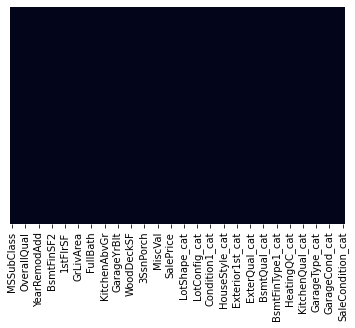

In [12]:
# para poder usar el KNNImputer necesito tirar las columnas categóricas viejas.
final_df.drop(categorical_features, axis = 1, inplace = True)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3, weights='distance') # uso 3 vecinos y se hace un promedio ponderado según la distancia euclidiana (a los más cercanos le da más peso)
final_df_imputed = imputer.fit_transform(final_df)
final_df_imputed = pd.DataFrame(final_df_imputed, columns=final_df.columns)

# Chequeo que efectivamente no haya más nan values
sns.heatmap(final_df_imputed.isnull(), yticklabels = False, cbar = False)
final_df_imputed.columns[final_df_imputed.isna().any()]

Como las columnas categóricas fueron codificadas con números, la predicción de las missing values se hace de forma numérica y me quedan floats muchas veces porque hace un promedio. Esto necesito que pase a ser un int así puedo mapearlo con el dictionario que tengo de antes.

In [13]:
new_categorical_features = []
for x in final_df_imputed.columns:
    if x[-4:] == '_cat':
        final_df_imputed[x] = final_df_imputed[x].astype(int)
        new_categorical_features.append(x)
final_df_imputed

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual_cat,Functional_cat,FireplaceQu_cat,GarageType_cat,GarageFinish_cat,GarageQual_cat,GarageCond_cat,PavedDrive_cat,SaleType_cat,SaleCondition_cat
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,2,6,4,1,1,4,4,2,8,4
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,3,6,4,1,1,4,4,2,8,4
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,2,6,4,1,1,4,4,2,8,4
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,2,6,2,5,2,4,4,2,8,0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,2,6,4,1,1,4,4,2,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160.0,21.0,1936.0,4.0,7.0,1970.0,1970.0,0.0,0.0,0.0,...,3,6,3,1,2,4,4,2,8,4
2915,160.0,21.0,1894.0,4.0,5.0,1970.0,1970.0,0.0,252.0,0.0,...,3,6,3,4,2,4,4,2,8,0
2916,20.0,160.0,20000.0,5.0,7.0,1960.0,1996.0,0.0,1224.0,0.0,...,3,6,4,5,2,4,4,2,8,0
2917,85.0,62.0,10441.0,5.0,5.0,1992.0,1992.0,0.0,337.0,0.0,...,3,6,3,2,1,3,3,2,8,4


In [14]:
# una vez llenos los missing values, hago el one hot encoding de las variables categóricas
# por comodidad lo hago con dummies
final_df_imputed = pd.get_dummies(final_df_imputed, columns=new_categorical_features)
final_df_imputed.shape

(2919, 276)

Ya está listo el pre-procesamiento de los datos. Ahora tengo que separar el train y el test set y comenzar con el desarrollo del modelo de machine learning

# Machine-Learning Model utilizando XGboost

 XGBoost Extreme Gradient Boosting es un algoritmo predictivo supervisado que utiliza el principio de **boosting**.
La idea detrás del **boosting** es generar múltiples modelos de predicción “débiles” secuencialmente, y que cada uno de estos tome los resultados del modelo anterior, para generar un modelo más “fuerte”, con mejor poder predictivo y mayor estabilidad en sus resultados.
Para conseguir un modelo más fuerte a partir de estos modelos débiles, se emplea un algoritmo de optimización, este caso **Gradient Descent** (descenso de gradiente).

In [15]:
# Separo los subsets
df_train = final_df_imputed.iloc[:1460,:]
df_test = final_df_imputed.iloc[1460:,:].drop(['SalePrice'], axis=1)

# Separo las variables descriptivas de lo que quiero predecir
# Me quedo con todo menos con SalePrice como X
X = df_train.drop(['SalePrice'],axis=1)
# Me quedo solo con SalePrice como y
y = df_train['SalePrice']

In [16]:
from sklearn.model_selection import KFold, cross_validate, train_test_split
import xgboost

# Separo el dataset de training en subsets training y testing 
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # Mantener el random state me permite replicar resultados

# Comienzo con el Regressor (uso regressor y no classiffier porque la variable a predecir es numérica)
regressor = xgboost.XGBRegressor(random_state = 0)

kf = KFold(n_splits=5, shuffle=True, random_state = 0)

scores = cross_validate(regressor, X, y, cv = kf, scoring="neg_mean_squared_log_error", n_jobs=-1)

## Fíjense Mariano y Ruso que esta vez no hice el train_test_split... Eso es porque seguí las instrucciones como estaban hechas en la guía de Optuna que leí. No se si hará falta hacer el split, o el split te lo hace automáticamente con la función cross_validate.... ver arriba

In [18]:
# Raíz del error cuadrático medio (RECM o RMSLE): es la calificación de Kaggle
rmsle = np.sqrt(-scores["test_score"].mean())
print(f"Base RMSLE: {rmsle:.5f}")

Base RMSLE: 0.14322


In [19]:
# Optimización con Optuna

import optuna  # pip install optuna

In [20]:
# Defino el search space: La finalidad de crear una función objective es 
# para definir el search space dentro de la misma, usando los metodos dentro
# del paquete de Optuna (ej. trial.suggest_int)

# El search space no es más que un diccionario. En donde se utilizan las funciones
# 'suggest' dentro del paquete Optuna 

#Estas funciones requieren por lo menos el nombre del hiperparámetro, un mínimo y un máximo
# del rango a buscar, o las posibles categorías para hiperparámetros categóricos.


def objective(trial, X, y, cv, scoring):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        ),
        "random_state": 0,
        "n_iter_no_change": 50,  # early stopping
        "validation_fraction": 0.05,
    }
    # Hacemos las cross validación para cada iteración de la función
    regressor = xgboost.XGBRegressor(**params)
    scores = cross_validate(regressor, X, y, cv = cv , scoring=scoring, n_jobs=-1)
    
    # En cada iteración me tira la raíz del error cuadrático medio (RMSLE)
    rmsle = np.sqrt(-scores["test_score"].mean())

    return rmsle

In [23]:
%%time

# Creo la variable study, que guradará y ejecutará el proceso de optimización
# La dirección la seteamos en minimizar para minimizar la loss function. Esto es
# por ejemplo cuando lo que buscamos es disminuir el RMSLE.
study = optuna.create_study(direction="minimize")

# Mismo Kfold que el anterior, se le pueden cambiar algunos parámetros
kf = KFold(n_splits=5, shuffle=True, random_state = 0)

# Wrap the objective inside a lambda with the relevant arguments, Pass additional arguments inside another function
func = lambda trial: objective(trial, X, y, cv=kf, scoring="neg_mean_squared_log_error")

# Empizo optimizando el estudio con 100 trials
study.optimize(func, n_trials=100)

[I 2021-07-31 20:02:13,754] A new study created in memory with name: no-name-b8bf4786-9bc5-4ebd-b677-195fe04adb48
[I 2021-07-31 20:03:20,929] Trial 0 finished with value: 0.147999710852238 and parameters: {'n_estimators': 1200, 'learning_rate': 0.002331636932348853, 'max_depth': 9, 'subsample': 0.7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.147999710852238.
[I 2021-07-31 20:03:32,123] Trial 1 finished with value: 0.1879430777606613 and parameters: {'n_estimators': 200, 'learning_rate': 0.010606993908977676, 'max_depth': 9, 'subsample': 0.8, 'max_features': 'log2'}. Best is trial 0 with value: 0.147999710852238.
[I 2021-07-31 20:05:31,567] Trial 2 finished with value: 0.13118919551715819 and parameters: {'n_estimators': 3000, 'learning_rate': 0.07630161315338208, 'max_depth': 6, 'subsample': 0.9, 'max_features': 'log2'}. Best is trial 2 with value: 0.13118919551715819.
[I 2021-07-31 20:07:32,935] Trial 3 finished with value: 0.1285498773721563 and parameters: {'n_estimators

CPU times: user 374 ms, sys: 229 ms, total: 603 ms
Wall time: 25min 26s


In [24]:
# Comparo como fué mejorando el RMSLE, antes y luego de la optimización

print(f"Base RMSLE     : {rmsle:.5f}")
print(f"Optimized RMSLE: {study.best_value:.5f}")

Base RMSLE     : 0.14322
Optimized RMSLE: 0.12357


In [25]:
#Imprimo los mejores parametros con los cuales setearé mi modelo
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	n_estimators: 4700
	learning_rate: 0.010838532718764182
	max_depth: 3
	subsample: 0.5
	max_features: auto


In [30]:
# Visualización de la optimización con Optuna

from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [29]:
# Visualización de la optimización con Optuna

from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

In [ ]:
#segundo estudio con un n_trials de 500 (tiempo estimado 10 horas en my compu) NO LO HICE
%%time
study.optimize(func, n_trials=500)

# La idea acá es tomar los datos del gráfico Hyperparameters Importance, y hacer un ajuste
# más fino en aquellos parámetros que tienen más importancia(ej. learning_rate)

In [ ]:
# Defino el regressor_final, con los parámetros obtenidos de study.best_params.items()

regressor_final = xgboost.XGBRegressor(n_estimators = 2300, 
                                       learning_rate = 0.011874309135432576, 
                                       max_depth = 4, 
                                       subsample = 0.5,
                                       max_features = 'sqrt'
                                      )

In [ ]:
# Fiteo el regressor_final

regressor_final.fit(X,y)

In [ ]:
# Predigo lo que quiero saber
SalePrice = regressor_final.predict(df_test)

# Le doy el formato que me pide Kaggle
Id = list(df_test.index)

df = pd.DataFrame()
df['Id'] = Id
df['Id'] = df['Id']+1
df['SalePrice'] = SalePrice
df.set_index('Id', drop=True, inplace=True)
df.to_csv('NIS_PD_submission_7.csv')

In [ ]:
df = pd.read_csv('NIS_PD_submission_6.csv')
df